In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot

In [2]:
def ConvertEventToNumpy(dfs, event):
    data = np.zeros(16)
    for i in range(16):
        if i in dfs:
            data[i] = dfs[i].loc[event]["amplitude"]
    data.shape = (4,4)
    return data

In [3]:
def GetAmplitudeSeedPixel(dfs, event, pixels = list(range(16))):
    maxAmplitude = 0
    maxPixel = -1
    for i in pixels:
        if i in dfs:
            amplitude = dfs[i].loc[event]["amplitude"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
    return maxPixel, maxAmplitude

In [4]:
def GetElectronsSeedPixel(dfs, event, pixels = [5,6,9,10]):
    maxAmplitude = 0
    maxPixel = -1
    for i in pixels:
        if i in dfs:
            amplitude = dfs[i].loc[event]["electrons"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
    return maxPixel, maxAmplitude

In [5]:
df = uproot.open("../Data/run175174828_230428174901_preprocessed.root")["PreprocessedData"]
nPixels = 16
dfs = {}

for i in range(nPixels):
    dfs[i] = df[f"pixel{i}"].arrays(library="pd")
dfs

{0:        pixel  samplingPeriod    baseline  minLevel  t10  t90  t50  fallTime  \
 0          0          250000  238.437040  235.7628 -2.0 -2.0 -2.0      -2.0   
 1          0          250000  238.624301  236.3724 -2.0 -2.0 -2.0      -2.0   
 2          0          250000  238.652876  235.6485 -2.0 -2.0 -2.0      -2.0   
 3          0          250000  238.822230  236.6391 -2.0 -2.0 -2.0      -2.0   
 4          0          250000  238.765271  236.4105 -2.0 -2.0 -2.0      -2.0   
 ...      ...             ...         ...       ...  ...  ...  ...       ...   
 47095      0          250000  236.597001  234.5055 -2.0 -2.0 -2.0      -2.0   
 47096      0          250000  236.844650  233.4768 -2.0 -2.0 -2.0      -2.0   
 47097      0          250000  237.436534  234.6960 -2.0 -2.0 -2.0      -2.0   
 47098      0          250000  236.758353  234.3150 -2.0 -2.0 -2.0      -2.0   
 47099      0          250000  237.121256  234.2007 -2.0 -2.0 -2.0      -2.0   
 
        amplitude  electrons       

<Axes: ylabel='Frequency'>

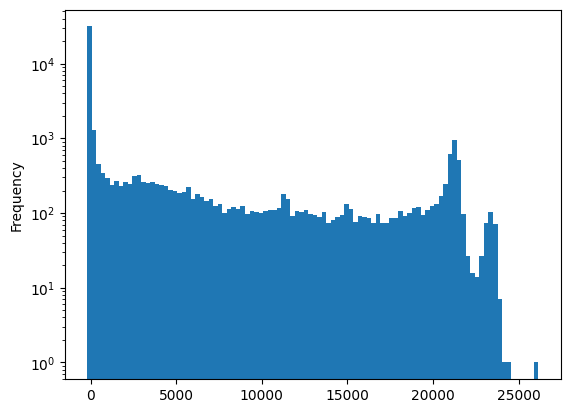

In [6]:
plt.yscale('log')
dfs[5]["electrons"].plot.hist(bins=100)


(6, 50.493892834289795)
(9, 25.132687404871053)


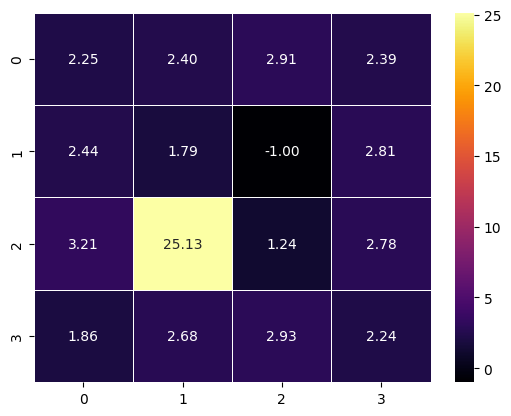

In [7]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs[0])):
    print(GetAmplitudeSeedPixel(dfs, i))
    if GetAmplitudeSeedPixel(dfs, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

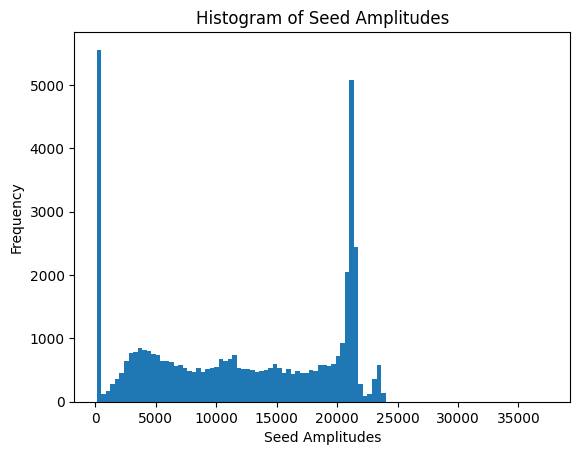

In [8]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetElectronsSeedPixel(dfs, i, pixels=[5,6,9,10])[1])
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.show()


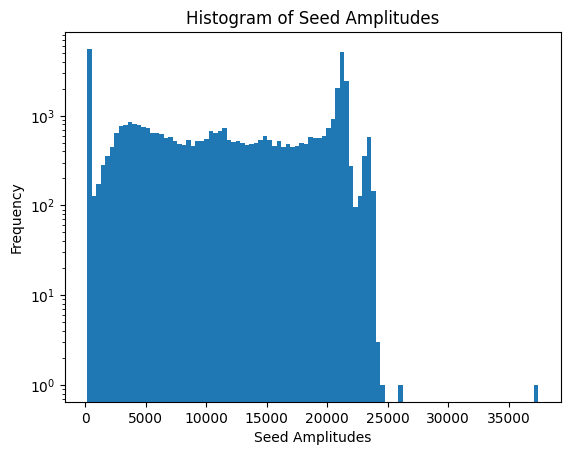

In [9]:
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.yscale('log')
plt.show()


In [10]:
def clusterize(dfs, event, threshold):
    data = ConvertEventToNumpy(dfs, event)
    cluster = np.zeros(16)
    NClusters = 0
    for i in range(4):
        for j in range(4):
            if data[i][j] > threshold:
                cluster[i*4+j] = 1
                NClusters += 1
    cluster.shape = (4,4)
    return cluster, NClusters

(array([30282., 14709.,  1409.,   700.]),
 array([0.  , 1.25, 2.5 , 3.75, 5.  ]),
 <BarContainer object of 4 artists>)

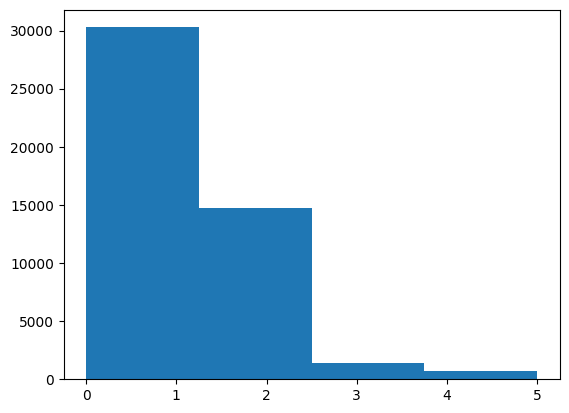

In [46]:
ClusterDistribution = []
for i in range(len(dfs[0])):
    ClusterDistribution.append(clusterize(dfs, i, 10)[1])



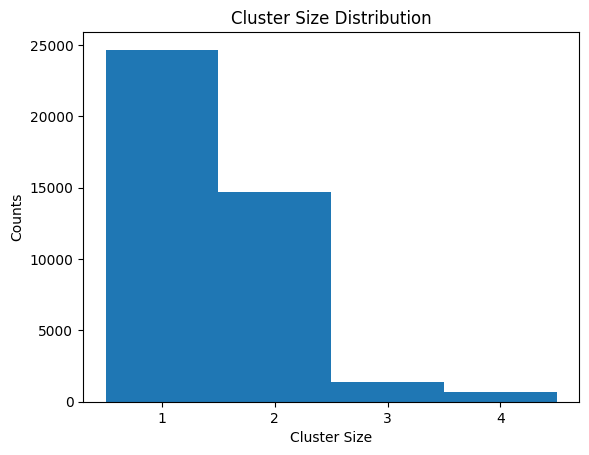

In [56]:
plt.hist(ClusterDistribution, bins=[0.5,1.5,2.5,3.5,4.5])
plt.xticks([1, 2, 3, 4])
plt.xlabel('Cluster Size')
plt.ylabel('Counts')
plt.title('Cluster Size Distribution')
plt.show()

In [47]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetElectronsSeedPixel(dfs, i)[1])
SeedAmplitudes = np.array(SeedAmplitudes)

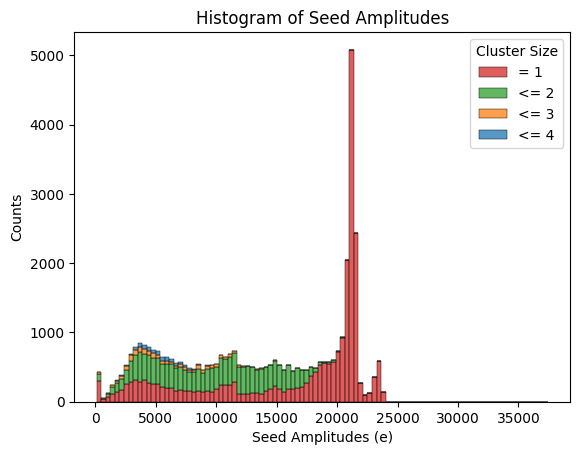

In [51]:
df_amplitudes_size = pd.DataFrame({"amplitude": SeedAmplitudes, "size": ClusterDistribution})
df_amplitudes_size['size'] = pd.Categorical(df_amplitudes_size['size'], [4,3,2,1])
sns.histplot(data = df_amplitudes_size, x="amplitude", hue="size", bins=100, multiple="stack")
# Set the legend labels in the desired order
legend_order = ['= 1', '<= 2', '<= 3', '<= 4']
plt.legend(title='Cluster Size', labels=legend_order)
plt.xlabel('Seed Amplitudes (e)')
plt.ylabel('Counts')
plt.title('Histogram of Seed Amplitudes')
plt.show()

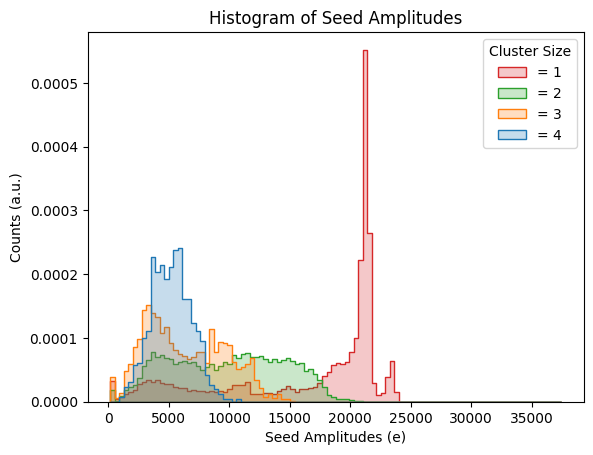

In [52]:
df_amplitudes_size = pd.DataFrame({"amplitude": SeedAmplitudes, "size": ClusterDistribution})
df_amplitudes_size['size'] = pd.Categorical(df_amplitudes_size['size'], [4,3,2,1])
sns.histplot(data = df_amplitudes_size, x="amplitude", hue="size", bins=100, multiple="layer", element="step",stat="density", common_norm=False,)
# Set the legend labels in the desired order
legend_order = ['= 1', '= 2', '= 3', '= 4']
plt.legend(title='Cluster Size', labels=legend_order)
plt.xlabel('Seed Amplitudes (e)')
plt.ylabel('Counts (a.u.)')
plt.title('Histogram of Seed Amplitudes')
plt.show()